# Function differentiation

This notebook shows how to differentiate functions represented as MPS using the SeeMPS library. We focus on the finite difference method, since the QFT is not yet optimally implemented to efficiently approximate derivatives. More information about these methods can be found in https://arxiv.org/abs/2303.09430.

First, let us import the necessary set of tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seemps.state import MPS
from seemps.analysis.derivatives import (
    finite_differences_mpo,
    fourier_derivative_mpo,
    hdaf_derivative_mpo,
)
from seemps.analysis.mesh import QuantizedInterval

The Gaussian function
\begin{equation}
    f(x) = \frac{1}{\mathcal{N}}e^{-x^2/2},
\end{equation}
where $\mathcal{N}$ is normalization constant, acts as benchmark for the differentiation techniques.

Let us define the functions to compute the error.

In [2]:
def projection(a, b):
    r"""
    Calculates the normalized projection between two vectors.

    The formula is

    .. math::

        cos(\theta) := \frac{|\langle{a|b}\rangle|}{\Vert{a}\Vert\Vert{b}\Vert}

    Parameters
    ----------
    a, b : numpy.ndarray or MPS
        The vectors or MPS to compare

    Returns
    -------
    float
        The cosine of the angle between two vectors.
    """
    if isinstance(a, MPS):
        a = a.to_vector()
    if isinstance(b, MPS):
        b = b.to_vector()
    return abs(np.vdot(a, b) / np.linalg.norm(a) / np.linalg.norm(b))

Let us study the error scaling with the number of qubits $n$, which is equivalent to studying how it varies with $\Delta x$. The finite difference function has a default minimum value of $\Delta x$ to avoid round-off error. This value can be modified according to the problem.

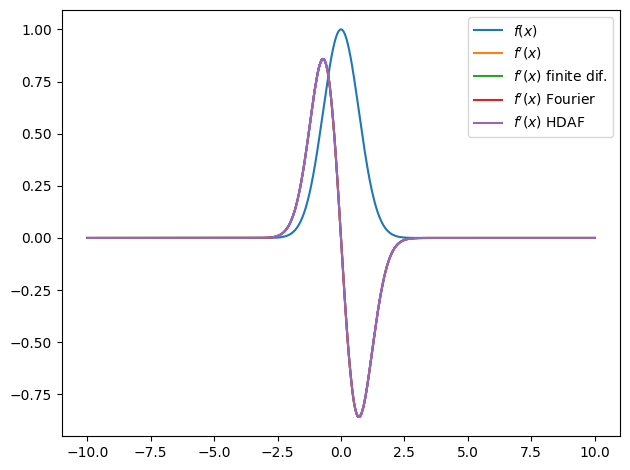

In [3]:
a, b = -10, 10
n_qubits = range(6, 23)
f = lambda x: np.exp(-(x**2))
df = lambda x: -2 * x * f(x)
errors = np.empty(shape=(len(n_qubits), 3))

for i, n in enumerate(n_qubits):
    interval = QuantizedInterval(a, b, n)
    x = interval.to_vector()
    f_mps = MPS.from_vector(f(x), [2] * n, normalize=False)
    K = finite_differences_mpo(
        order=1, filter=9, interval=interval, periodic=True, tol=1e-3
    )
    df_mps1 = K @ f_mps
    errors[i, 0] = 1 - projection(df_mps1, df(x))
    K = fourier_derivative_mpo(order=1, interval=interval)
    df_mps2 = K @ f_mps
    errors[i, 1] = 1 - projection(df_mps2, df(x))
    K = hdaf_derivative_mpo(order=1, interval=interval, M=6)
    df_mps3 = K @ f_mps
    errors[i, 2] = 1 - projection(df_mps2, df(x))
    if n == 20:
        fig, ax = plt.subplots()
        ax.plot(x, f(x), label=r"$f(x)$")
        ax.plot(x, df(x), label=r"$f'(x)$")
        ax.plot(x, np.real(df_mps1.to_vector()), label=r"$f'(x)$ finite dif.")
        ax.plot(x, np.real(df_mps2.to_vector()), label=r"$f'(x)$ Fourier")
        ax.plot(x, np.real(df_mps3.to_vector()), label=r"$f'(x)$ HDAF")
        ax.legend()
        fig.tight_layout()

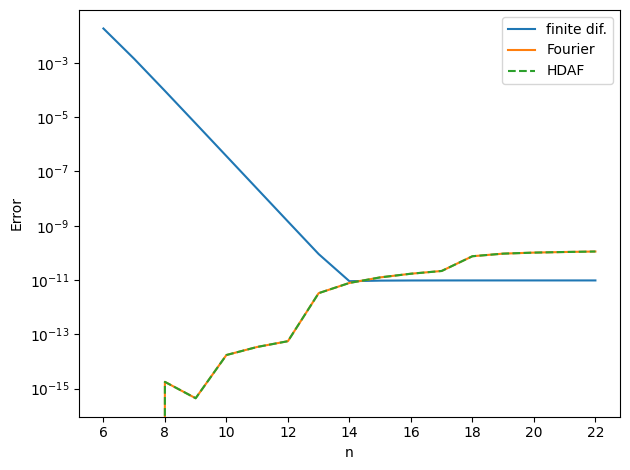

In [4]:
fig, ax = plt.subplots()
ax.set_xlabel("n")
ax.set_ylabel("Error")
ax.set_xticks(n_qubits[::2], n_qubits[::2])
ax.plot(n_qubits, errors[:, 0], label="finite dif.")
ax.plot(n_qubits, errors[:, 1], label="Fourier")
ax.plot(n_qubits, errors[:, 2], "--", label="HDAF")
ax.legend()
ax.set_yscale("log")
plt.tight_layout()